In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn
import scipy.optimize
import matplotlib.pyplot as plt
import sys

import dbclients.tantalus
import datamanagement.transfer_files

import envsetup

results_storage_name = 'singlecellblob_results'
local_storage_name = 'andrewvm'
local_storage_directory = '/home/ubuntu/tantalus_data/'

# rt_bedgraph = '/home/ubuntu/refdata/RT_MCF-7_Adenocarcinoma_Int67688290_hg19.bedgraph'


2019-02-28 23:37:55,235 - INFO - bef127a0-f3cb-446c-a594-ece4353ed093 - TokenRequest:Getting token with client credentials.
2019-02-28 23:37:55,429 - INFO - bef127a0-f3cb-446c-a594-ece4353ed093 - OAuth2Client:Get Token Server returned this correlation_id: bef127a0-f3cb-446c-a594-ece4353ed093
2019-02-28 23:37:55,720 - INFO - skipping caching of SC-1563/results/results/hmmcopy_autoploidy/plots/A90553C_metrics.pdf
2019-02-28 23:37:55,721 - INFO - skipping caching of SC-1563/results/results/hmmcopy_autoploidy/plots/A90553C_kernel_density.pdf
2019-02-28 23:37:55,722 - INFO - skipping caching of SC-1563/results/results/hmmcopy_autoploidy/plots/A90553C_heatmap_by_ec_filtered.pdf
2019-02-28 23:37:55,723 - INFO - skipping caching of SC-1563/results/results/hmmcopy_autoploidy/plots/bias/A90553C_bias.tar.gz
2019-02-28 23:37:55,724 - INFO - skipping caching of SC-1563/results/results/hmmcopy_autoploidy/plots/A90553C_heatmap_by_ec.pdf
2019-02-28 23:37:55,725 - INFO - starting caching SC-1563/result

concatenate hmmcopy_reads
concatenate hmmcopy_metrics
concatenate align_metrics
library_id
A90553C    1700
A96139A    1464
A73044A    1350
A96147A    2082
dtype: int64
library_id
A90553C    1408
A96139A    1317
A73044A     957
A96147A    1880
dtype: int64


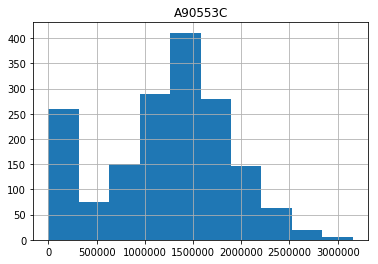

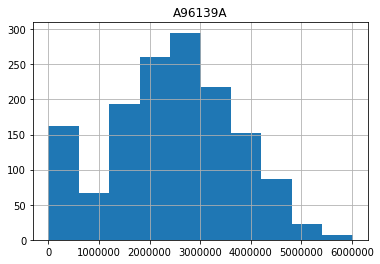

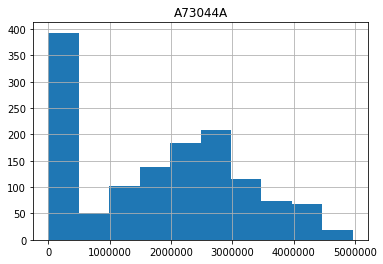

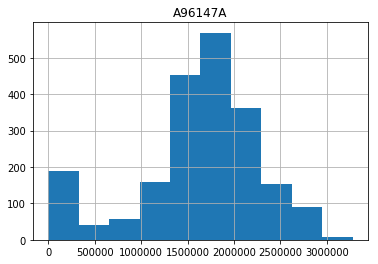

In [2]:

import scgenome.dataimport

tickets = [
    'SC-1563',
    'SC-1561',
    'SC-1583',
    'SC-1585',
]

sample_ids = [
    'SA928',
    'SA1044',
]

results = scgenome.dataimport.import_cn_data(
    tickets,
    local_storage_directory,
    sample_ids=sample_ids,
)

cn_data = results['hmmcopy_reads']
metrics_data = results['hmmcopy_metrics']
align_metrics_data = results['align_metrics']

for library_id, library_metrics_data in metrics_data.groupby('library_id'):
    plt.figure()
    library_metrics_data['total_mapped_reads'].hist()
    plt.title(library_id)

print(metrics_data.groupby('library_id').size())

metrics_data = metrics_data.query('total_mapped_reads > 500000')

print(metrics_data.groupby('library_id').size())

cn_data = cn_data.merge(metrics_data[['cell_id']].drop_duplicates())
cn_data = cn_data.merge(metrics_data[['cell_id', 'experimental_condition']])


In [3]:

conditions = {
    'A': 'G1',
    'A-BSA': 'G1',
    'A-NCC': 'G1',
    'B': 'S',
    'B-NCC': 'S',
    'C': 'G2',
    'C-NCC': 'G2',
    'G1': 'G1',
    'G2': 'G2',
    'S': 'S',
    'D': 'D',
}

conditions = pd.Series(conditions)
conditions.index.name = 'experimental_condition'
conditions.name = 'cell_cycle_state'
conditions = conditions.reset_index()

metrics_data = metrics_data.merge(conditions)
cn_data = cn_data.merge(conditions)

metrics_data = metrics_data.query('cell_cycle_state != "D"')
cn_data = cn_data.query('cell_cycle_state != "D"')


/anaconda/envs/scgenome/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


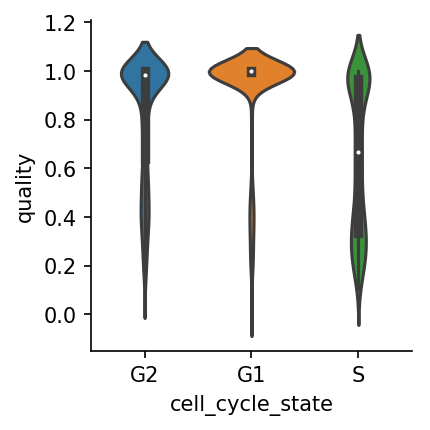

In [4]:


g = seaborn.catplot(
    x='cell_cycle_state',
    y='quality',
    data=metrics_data,
    kind='violin',
    height=3,
)
g.fig.dpi = 150


In [7]:

print(metrics_data.groupby('library_id').size())


library_id
A90553C    1139
A96139A    1023
A73044A     771
A96147A    1095
dtype: int64


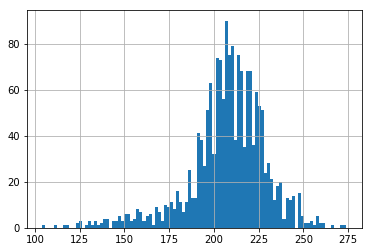

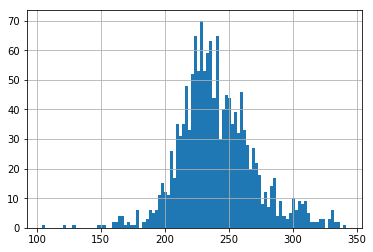

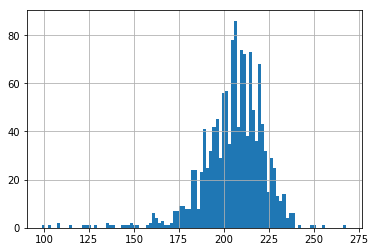

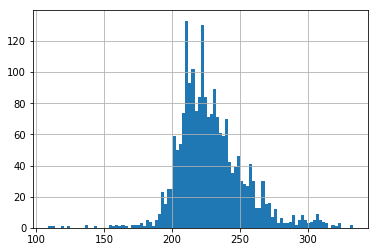

In [6]:

for library_id, df in align_metrics_data.groupby('library_id'):
    plt.figure()
    df['median_insert_size'].hist(bins=100)

cn_data = cn_data.merge(align_metrics_data[['cell_id', 'median_insert_size']])


In [8]:


def subset_by_cell_cycle(cn_data, proportion_s):
    cell_states = cn_data[['cell_id', 'cell_cycle_state']].drop_duplicates()
    state_cell_ids = {}
    for cell_cycle_state, df in cell_states.groupby('cell_cycle_state'):
        state_cell_ids[cell_cycle_state] = shuffle(df['cell_id'].values.astype(str))

    num_cells = len(state_cell_ids['S'])
    cell_ids = (
        list(state_cell_ids['S'][:int(proportion_s * num_cells)]) +
        list(state_cell_ids['G1'][:int((1. - proportion_s) * num_cells)])
    )
    
    return cell_ids


def calculate_features(cn_data, metrics_data, align_metrics_data, agg_proportion_s=None, plots=False):

    corr_data = []

    for library_id, library_cn_data in cn_data.groupby('library_id'):
        library_cn_data = library_cn_data[library_cn_data['gc'] < 1.]
        library_cn_data = library_cn_data[library_cn_data['gc'] > 0.]
        library_cn_data = library_cn_data[library_cn_data['state'] < 9]

        library_cn_data = library_cn_data.merge(
            library_cn_data.groupby('cell_id')['reads'].sum().rename('total_reads').reset_index())
        library_cn_data['norm_reads'] = 1e6 * library_cn_data['reads'] / library_cn_data['total_reads']
        library_cn_data = library_cn_data.query('state > 0')
        library_cn_data['norm_reads'] = library_cn_data['norm_reads'] / library_cn_data['state']

        #
        # Correct GC with aggregate data
        #
        for use_norm_reads in (True, False):
            if use_norm_reads:
                reads_col = 'norm_reads'
            else:
                reads_col = 'reads'

            if agg_proportion_s is not None:
                cell_ids = subset_by_cell_cycle(library_cn_data, agg_proportion_s)
                agg_data = library_cn_data[library_cn_data['cell_id'].isin(cell_ids)]
            else:
                agg_data = library_cn_data
            agg_data = agg_data.groupby(['chr', 'start'])[reads_col].sum().reset_index()
            agg_data = agg_data.merge(cn_data[['chr', 'start', 'gc']].drop_duplicates())

            if plots:
                fig = plt.figure(figsize=(3, 3))
                ax = plt.gca()
                seaborn.scatterplot(
                    'gc', reads_col,
                    data=agg_data,
                    alpha=0.01,
                    ax=ax)

            z = np.polyfit(agg_data['gc'].values, agg_data[reads_col].values, 3)
            p = np.poly1d(z)

            if plots:
                x = np.linspace(agg_data['gc'].min(), agg_data['gc'].max(), 100)
                plt.plot(x, p(x))
                plt.title('agg fit on ' + library_id)

            library_cn_data['copy2_{}'.format(use_norm_reads * 1)] = library_cn_data[reads_col] / p(library_cn_data['gc'].values)

        #
        # Correct GC with per cell data
        #
        for use_insert_size in (True, False):
            if agg_proportion_s is not None:
                cell_ids = subset_by_cell_cycle(library_cn_data, agg_proportion_s)
                agg_data = library_cn_data[library_cn_data['cell_id'].isin(cell_ids)]
            else:
                agg_data = library_cn_data

            if use_insert_size:
                X = agg_data[['gc', 'median_insert_size']].values
            else:
                X = agg_data[['gc']].values

            y = agg_data['norm_reads']

            poly = PolynomialFeatures(3)
            X_poly = poly.fit_transform(X)

            reg = LinearRegression().fit(X_poly, y)

#             print(
#                 'Library {}, accuracy of Logistic regression classifier on training set: {:.4f}'
#                 .format(library_id, reg.score(X_poly, y)))

            if use_insert_size:
                X = library_cn_data[['gc', 'median_insert_size']].values
            else:
                X = library_cn_data[['gc']].values

            X_poly = poly.fit_transform(X)

            corrected_column = 'copy3_{}'.format(use_insert_size * 1)
            library_cn_data[corrected_column] = library_cn_data['norm_reads'] / reg.predict(X_poly)

            cell_id = library_cn_data.sort_values('total_reads')['cell_id'].iloc[0]
            plot_data = library_cn_data.query('cell_id == "{}"'.format(cell_id))

            median_insert_size = plot_data['median_insert_size'].values[0]
            if 'cell_cycle_state' in plot_data:
                cell_cycle_state = plot_data['cell_cycle_state'].values[0]
            else:
                cell_cycle_state = 'unknown'

            if plots:
                fig = plt.figure(figsize=(6, 6))
                ax = plt.gca()
                seaborn.scatterplot(
                    'gc', 'norm_reads',
                    data=plot_data,
                    alpha=0.1,
                    ax=ax)

            x = np.linspace(plot_data['gc'].min(), plot_data['gc'].max(), 100)

            if use_insert_size:
                x = np.array([x, median_insert_size * np.ones(x.shape)]).T
            else:
                x = np.array([x]).T

            if plots:
                plt.plot(x[:, 0], reg.predict(poly.fit_transform(x)))
                plt.title('gc norm reads ' + corrected_column + ' ' + cell_id + ' ' + cell_cycle_state)

            if plots:
                fig = plt.figure(figsize=(6, 6))
                ax = plt.gca()
                seaborn.scatterplot(
                    'gc', corrected_column,
                    data=plot_data,
                    alpha=0.1,
                    ax=ax)
                plt.title('gc corrected ' + corrected_column + ' ' + cell_id + ' ' + cell_cycle_state)

        library_corr_data = []
        for cell_id, cell_data in library_cn_data.groupby('cell_id'):
            if cell_data.empty:
                continue
            correlation0, pvalue = scipy.stats.spearmanr(cell_data['gc'], cell_data['copy2_0'])
            correlation1, pvalue = scipy.stats.spearmanr(cell_data['gc'], cell_data['copy2_1'])
            correlation2, pvalue = scipy.stats.spearmanr(cell_data['gc'], cell_data['copy3_0'])
            correlation3, pvalue = scipy.stats.spearmanr(cell_data['gc'], cell_data['copy3_1'])
            correlation, pvalue = scipy.stats.spearmanr(cell_data['gc'], cell_data['norm_reads'])
            slope0 = np.polyfit(cell_data['gc'].values, cell_data['copy2_0'].values, 1)[1]
            slope1 = np.polyfit(cell_data['gc'].values, cell_data['copy2_1'].values, 1)[1]
            slope3 = np.polyfit(cell_data['gc'].values, cell_data['copy3_0'].values, 1)[1]
            slope2 = np.polyfit(cell_data['gc'].values, cell_data['copy3_1'].values, 1)[1]
            slope = np.polyfit(cell_data['gc'].values, cell_data['norm_reads'].values, 1)[1]
            library_corr_data.append(dict(
                correlation=correlation,
                correlation0=correlation0,
                correlation1=correlation1,
                correlation2=correlation2,
                correlation3=correlation3,
                pvalue=pvalue,
                cell_id=cell_id,
                slope0=slope0,
                slope1=slope1,
                slope2=slope2,
                slope3=slope3,
                slope=slope,
            ))
        library_corr_data = pd.DataFrame(library_corr_data)
        library_corr_data['library_id'] = library_id

        corr_data.append(library_corr_data)

        if plots:
            fig = plt.figure(figsize=(6, 6))
            library_corr_data['correlation'].hist(bins=100)
            plt.title('correlation hist ' + library_id)

    corr_data = pd.concat(corr_data, ignore_index=True)
    
    ploidy = cn_data.groupby('cell_id')['state'].mean().rename('ploidy').reset_index()

    corr_data = corr_data.merge(align_metrics_data[align_metrics_columns].drop_duplicates())
    corr_data = corr_data.merge(metrics_data[['cell_id', 'breakpoints']].drop_duplicates())
    if 'cell_cycle_state' in metrics_data:
        corr_data = corr_data.merge(metrics_data[['cell_id', 'cell_cycle_state']].drop_duplicates())
    corr_data = corr_data.merge(ploidy)
    
    return corr_data




0.0


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

Accuracy of classifier on training set: 0.89


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

cell_cycle_state
G1    397
G2    308
S     302
dtype: int64


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda/envs/scgenome/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Accuracy of classifier on test set: 0.85
Accuracy 0.8510427010923535
Precision 0.7235294117647059
0.1


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

Accuracy of classifier on training set: 0.89


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

cell_cycle_state
G1    397
G2    308
S     302
dtype: int64
Accuracy of classifier on test set: 0.87


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda/envs/scgenome/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Accuracy 0.8728897715988083
Precision 0.7861842105263158
0.2


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

Accuracy of classifier on training set: 0.89


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

cell_cycle_state
G1    397
G2    308
S     302
dtype: int64


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda/envs/scgenome/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Accuracy of classifier on test set: 0.89
Accuracy 0.8857994041708044
Precision 0.8375451263537906
0.30000000000000004


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

Accuracy of classifier on training set: 0.89


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

cell_cycle_state
G1    397
G2    308
S     302
dtype: int64


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda/envs/scgenome/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Accuracy of classifier on test set: 0.89
Accuracy 0.8927507447864945
Precision 0.8849206349206349
0.4


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

Accuracy of classifier on training set: 0.89


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

cell_cycle_state
G1    397
G2    308
S     302
dtype: int64


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda/envs/scgenome/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Accuracy of classifier on test set: 0.90
Accuracy 0.8987090367428004
Precision 0.923728813559322
0.5


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

Accuracy of classifier on training set: 0.89


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

cell_cycle_state
G1    397
G2    308
S     302
dtype: int64
Accuracy of classifier on test set: 0.89


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

Accuracy 0.8917576961271102
Precision 0.9617224880382775
0.6000000000000001


/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

Accuracy of classifier on training set: 0.89


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

cell_cycle_state
G1    397
G2    308
S     302
dtype: int64
Accuracy of classifier on test set: 0.88


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

Accuracy 0.8758689175769613
Precision 0.9682539682539683
0.7000000000000001


/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

Accuracy of classifier on training set: 0.89


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

cell_cycle_state
G1    397
G2    308
S     302
dtype: int64


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

Accuracy of classifier on test set: 0.86
Accuracy 0.8570009930486594
Precision 0.9876543209876543
0.8


/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

Accuracy of classifier on training set: 0.89


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

cell_cycle_state
G1    397
G2    308
S     302
dtype: int64
Accuracy of classifier on test set: 0.83


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

Accuracy 0.8321747765640516
Precision 0.9925925925925926
0.9


/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

Accuracy of classifier on training set: 0.89


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

cell_cycle_state
G1    397
G2    308
S     302
dtype: int64


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

Accuracy of classifier on test set: 0.81
Accuracy 0.8113207547169812
Precision 0.9912280701754386
1.0


/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

Accuracy of classifier on training set: 0.89


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

cell_cycle_state
G1    397
G2    308
S     302
dtype: int64


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

Accuracy of classifier on test set: 0.78
Accuracy 0.7785501489572989
Precision 0.9876543209876543


/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


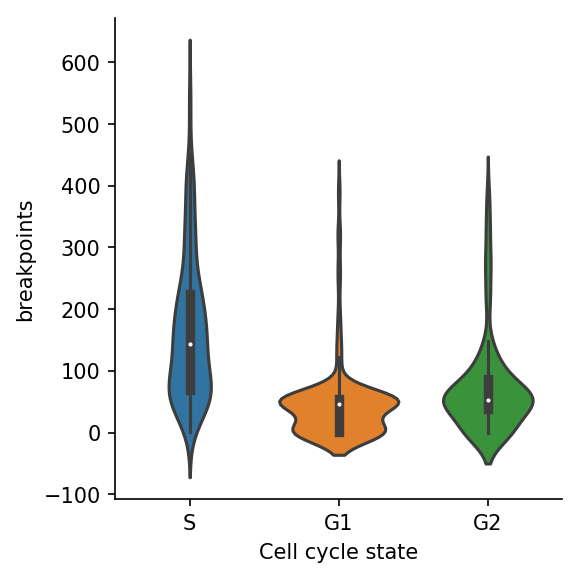

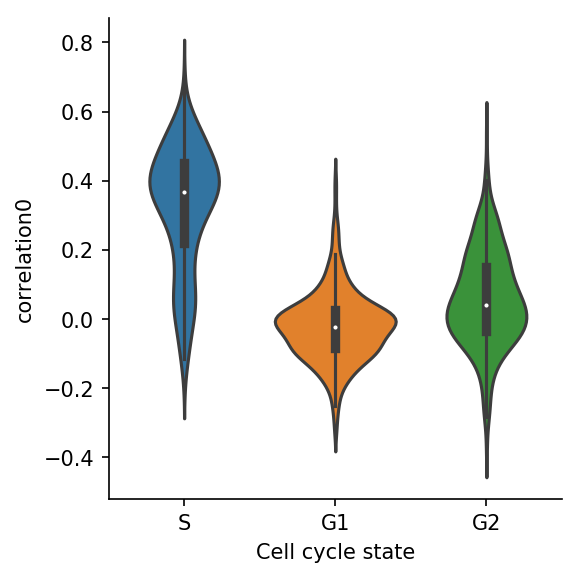

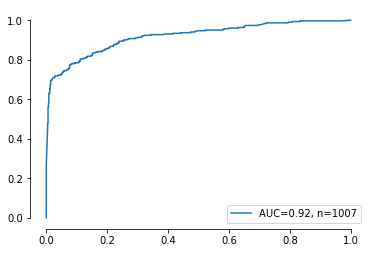

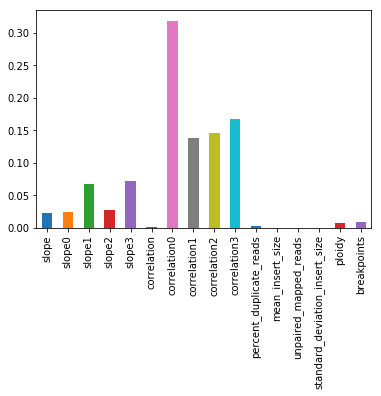

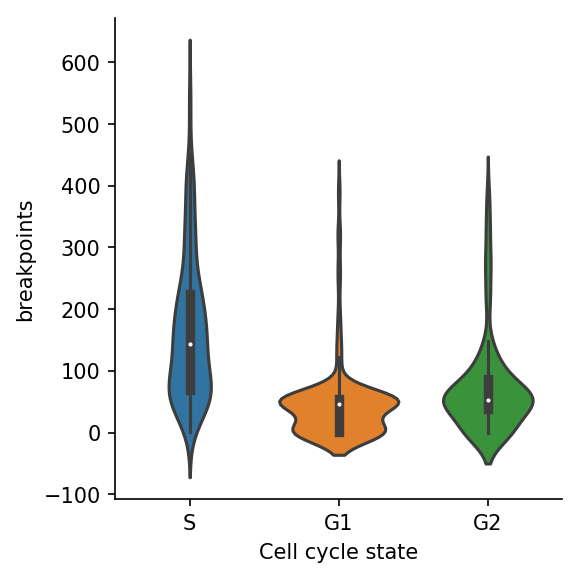

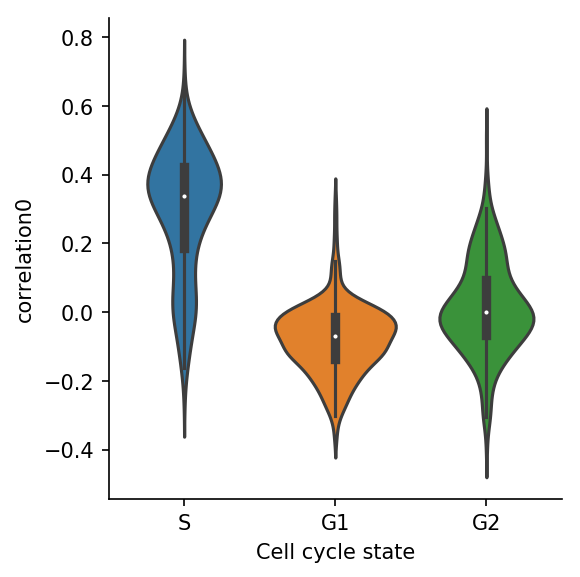

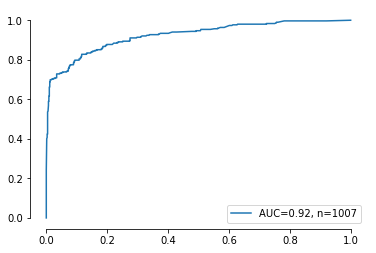

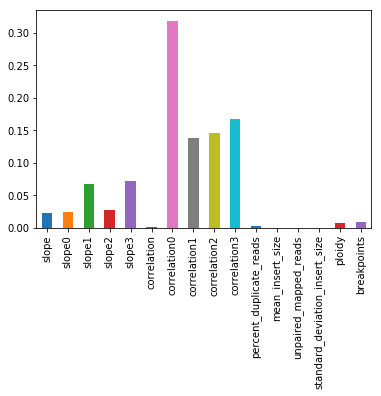

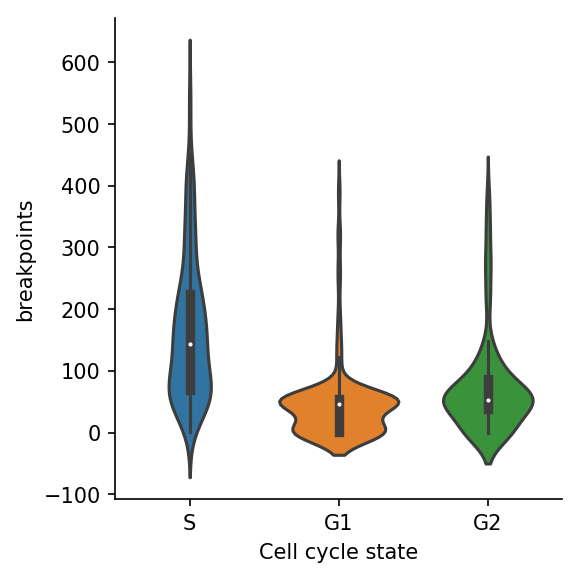

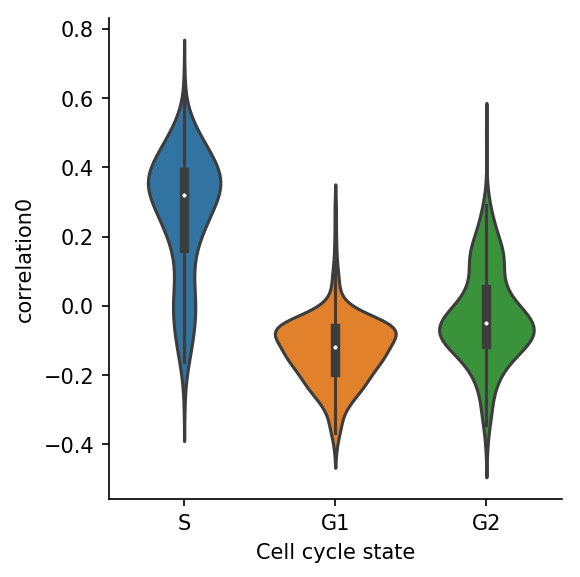

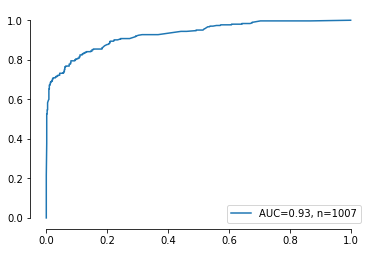

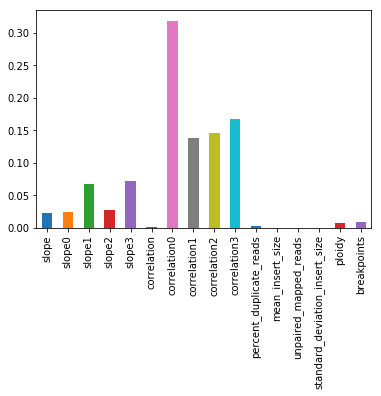

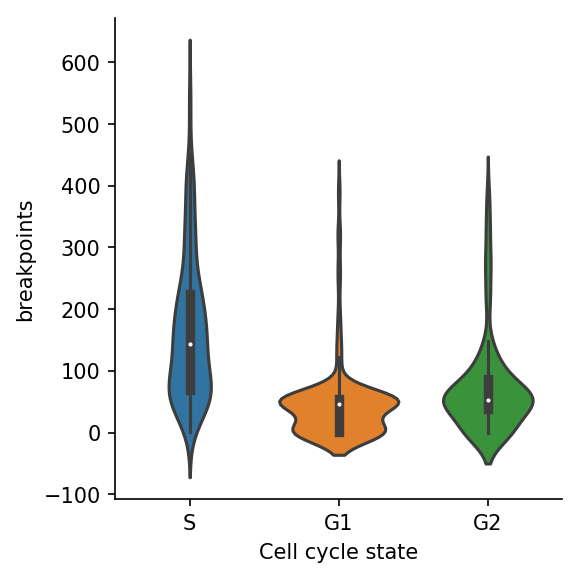

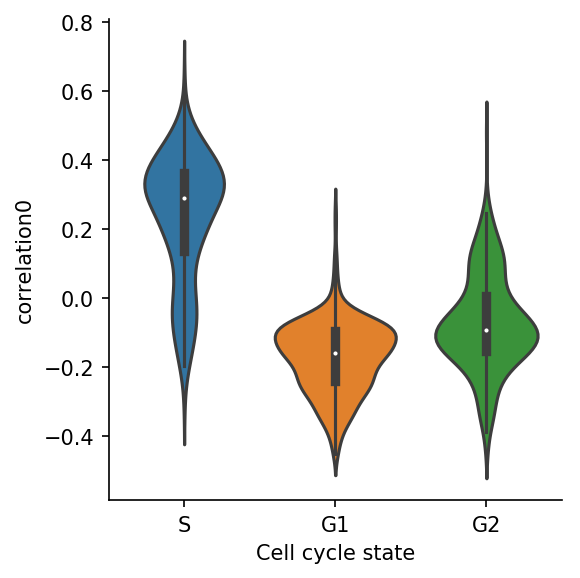

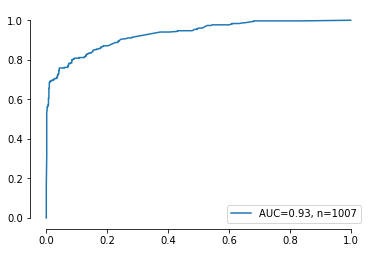

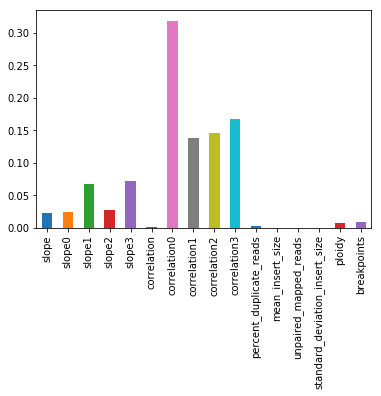

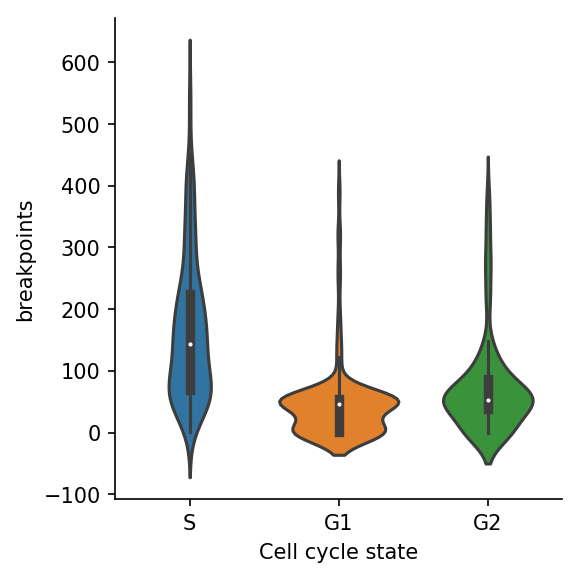

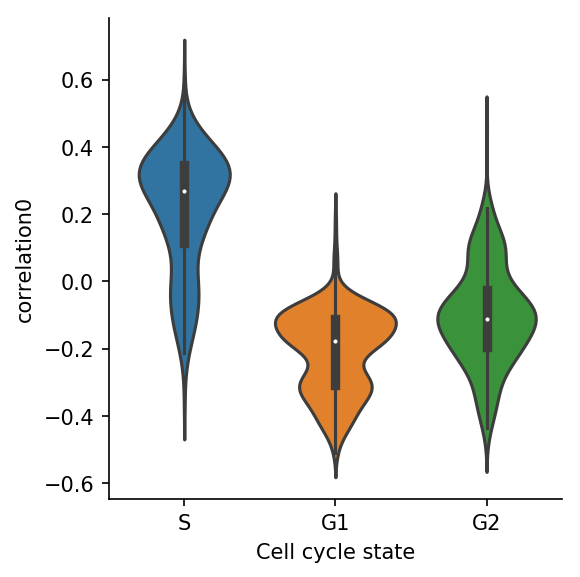

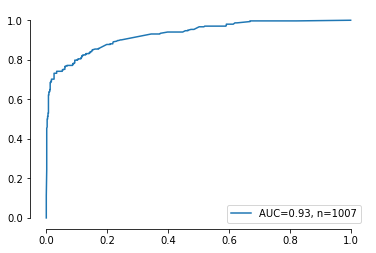

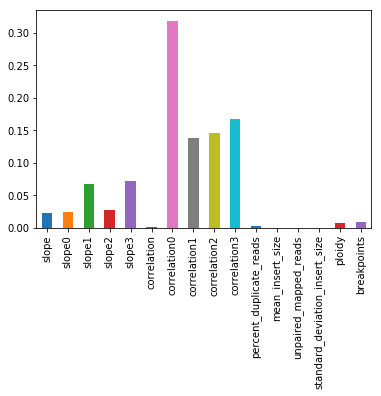

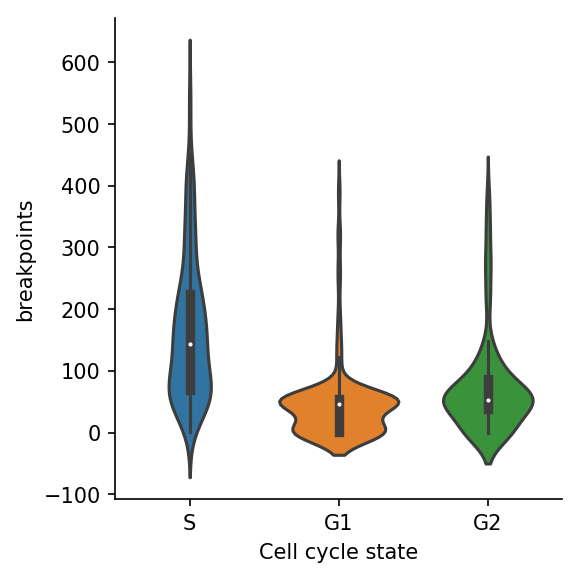

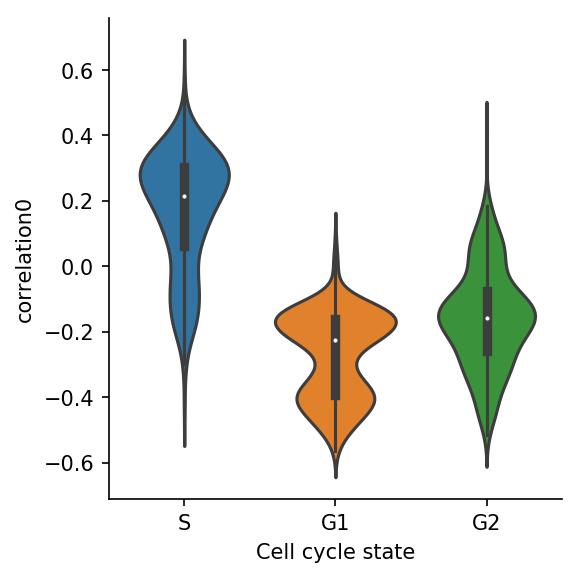

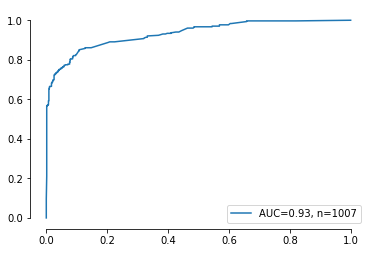

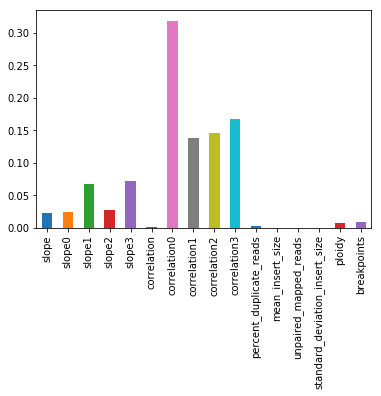

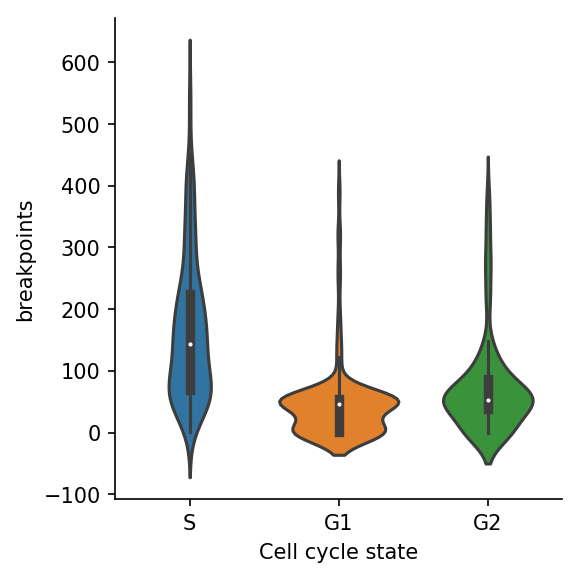

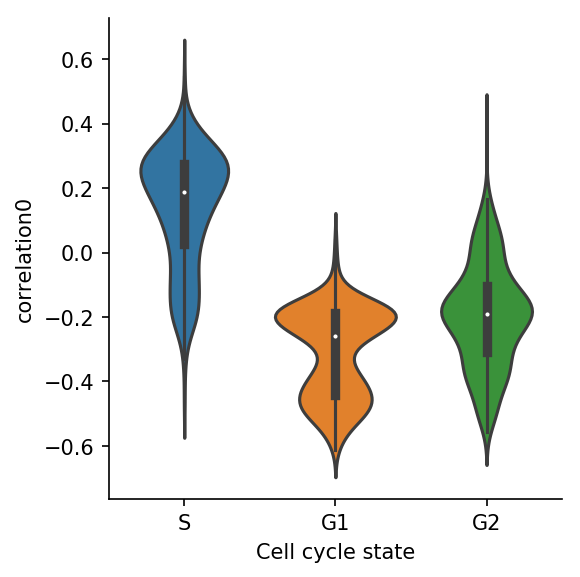

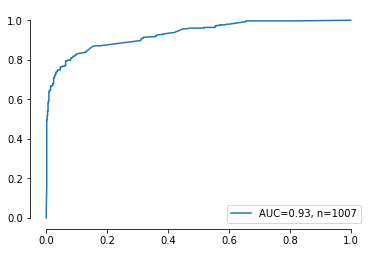

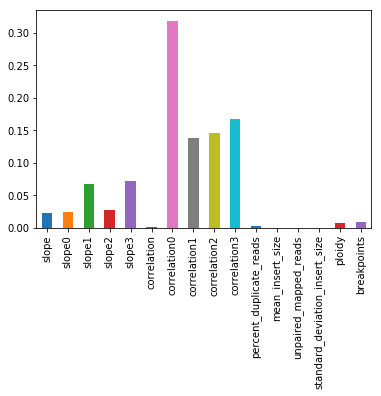

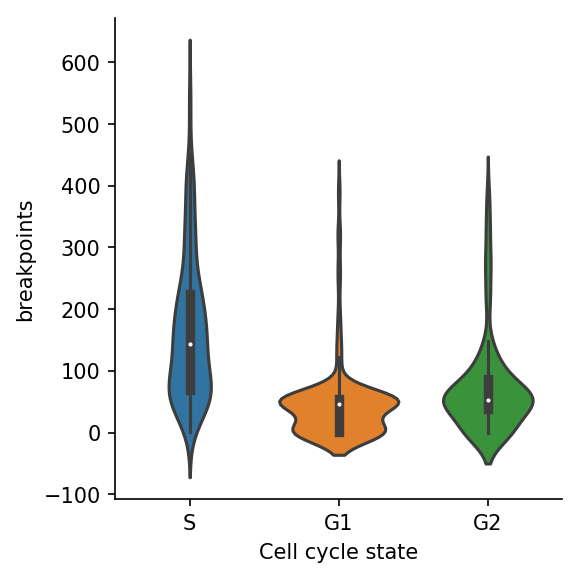

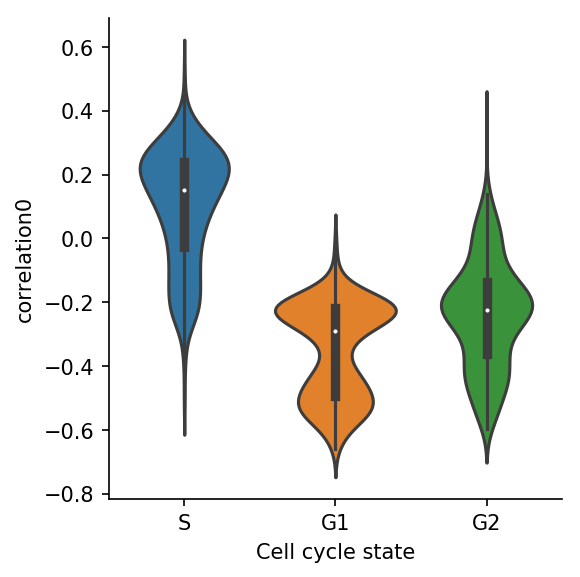

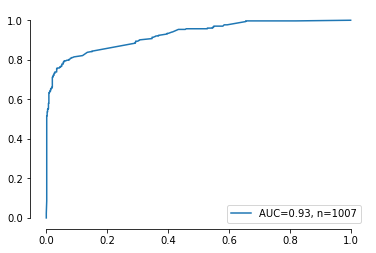

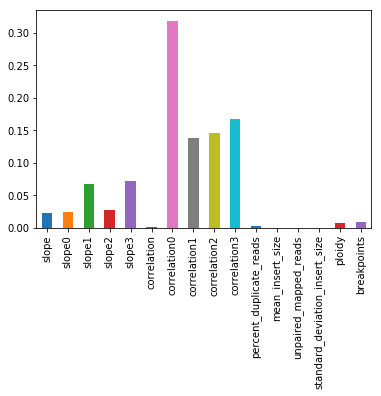

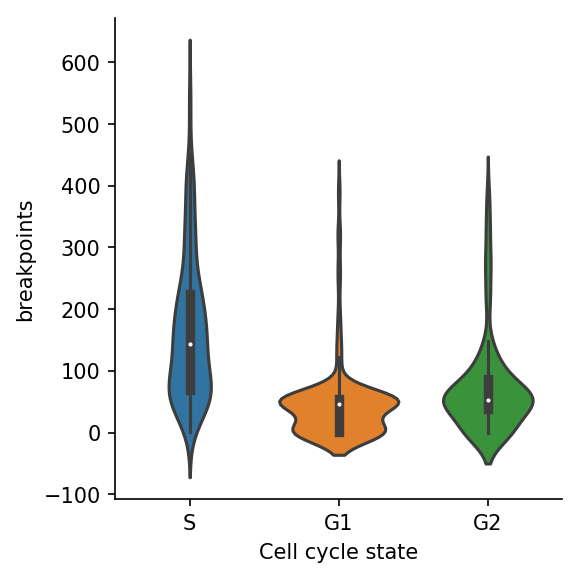

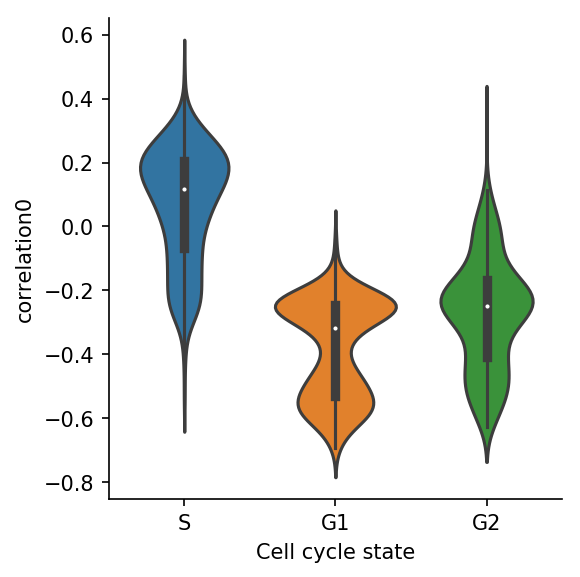

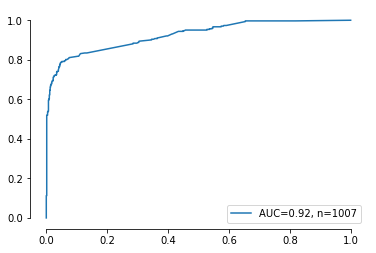

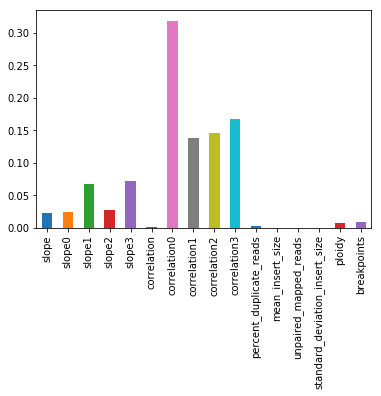

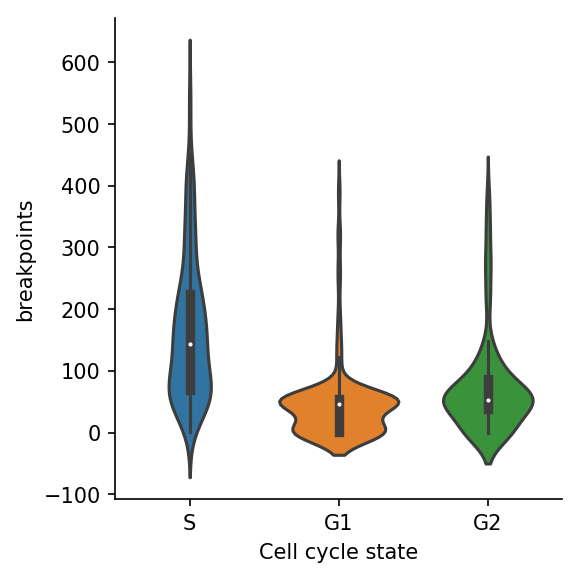

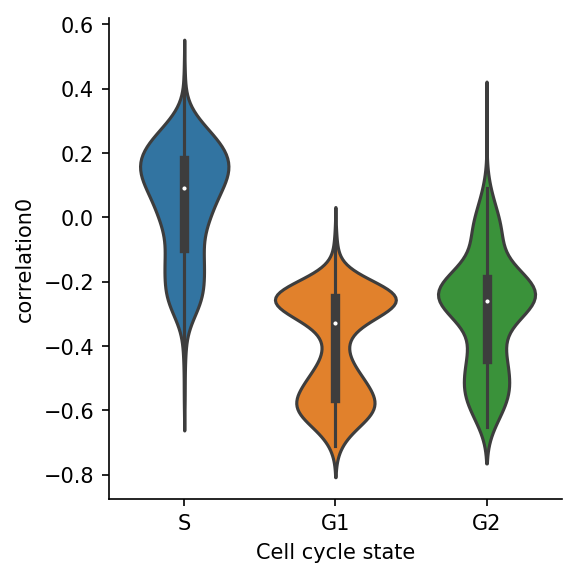

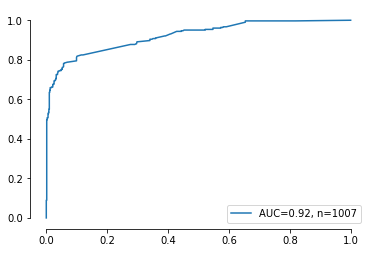

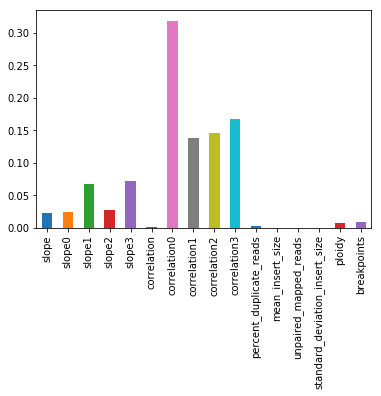

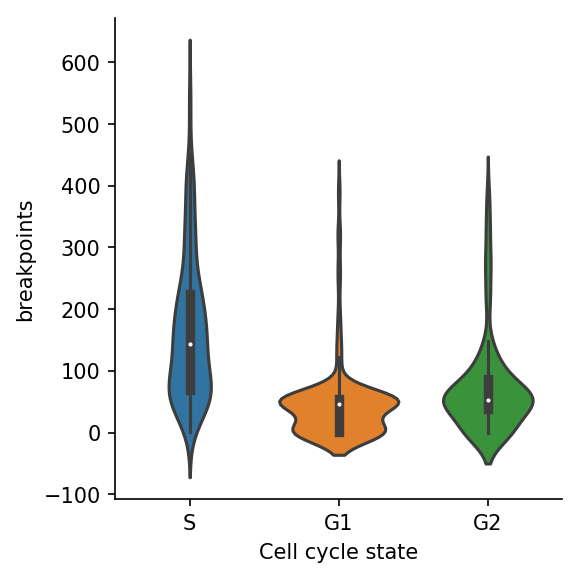

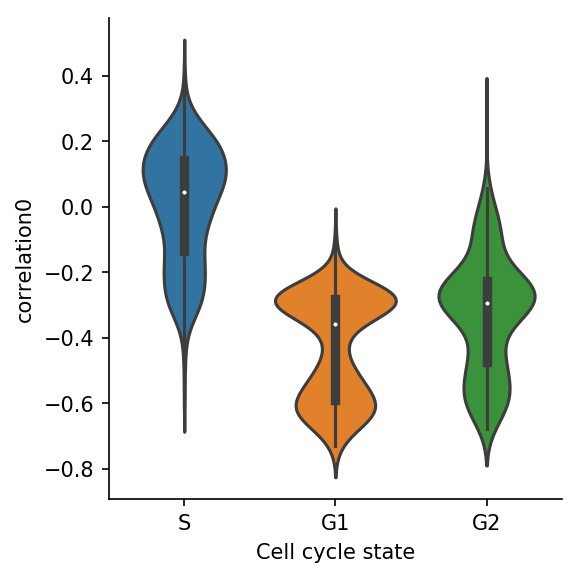

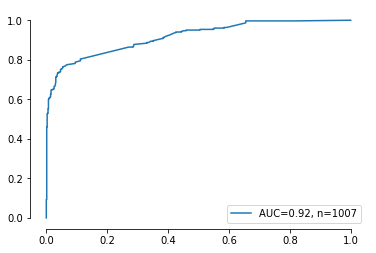

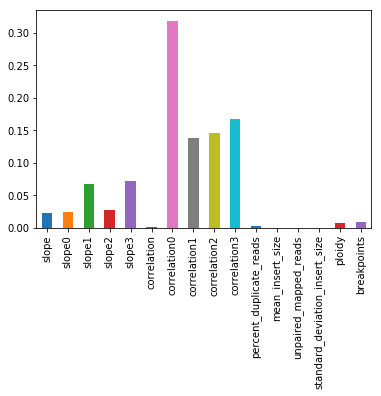

In [11]:

import seaborn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures

features = [
    'slope',
    'slope0',
    'slope1',
    'slope2',
    'slope3',
    'correlation',
    'correlation0',
    'correlation1',
    'correlation2',
    'correlation3',
    'percent_duplicate_reads',
    'mean_insert_size',
    'unpaired_mapped_reads',
    'standard_deviation_insert_size',
    'ploidy',
    'breakpoints',
]

align_metrics_columns = [
    'cell_id',
    u'unpaired_mapped_reads', u'paired_mapped_reads',
    u'unpaired_duplicate_reads', u'paired_duplicate_reads',
    u'unmapped_reads', u'percent_duplicate_reads',
    u'total_reads', u'total_mapped_reads',
    u'total_duplicate_reads', u'total_properly_paired', u'coverage_breadth',
    u'coverage_depth', u'median_insert_size', u'mean_insert_size',
    u'standard_deviation_insert_size',
]

def train_model(corr_data):
    X = corr_data[features].values
    y = corr_data['cell_cycle_state'].values == 'S'

    model = RandomForestClassifier(
        n_estimators=100, max_depth=2,
        random_state=0)

    model.fit(X, y)

    print(
        'Accuracy of classifier on training set: {:.2f}'
        .format(model.score(X, y)))

    return model

cell_ids = cn_data['cell_id'].unique().astype(str)
cell_ids = shuffle(cell_ids)

split_idx = int(0.75 * len(cell_ids))
training_cell_ids = cell_ids[:split_idx]
test_cell_ids = cell_ids[split_idx:]


prop_s_data = []

for proportion_s in np.linspace(0, 1, 11):
    print(proportion_s)

    # Train
    #
    training_data = calculate_features(
        cn_data[cn_data['cell_id'].isin(training_cell_ids)],
        metrics_data,
        align_metrics_data,
    )

    training_data = training_data.query('cell_cycle_state != "D"')
    training_data = training_data.query('ploidy < 6')

    model = train_model(training_data)

    # Test
    # 
    testing_data = calculate_features(
        cn_data[cn_data['cell_id'].isin(test_cell_ids)],
        metrics_data,
        align_metrics_data,
        agg_proportion_s=proportion_s,
    )

    testing_data = testing_data.query('cell_cycle_state != "D"')
    print(testing_data.groupby('cell_cycle_state').size())

    g = seaborn.factorplot(
        y='breakpoints',
        x='cell_cycle_state',
        data=testing_data,
        kind='violin',
        height=4,
    )
    g.fig.dpi = 150
    g.axes[0][0].set_xlabel('Cell cycle state')

    g = seaborn.factorplot(
        y='correlation0',
        x='cell_cycle_state',
        data=testing_data,
        kind='violin',
        height=4,
    )
    g.fig.dpi = 150
    g.axes[0][0].set_xlabel('Cell cycle state')

    X = testing_data[features].values
    y = testing_data['cell_cycle_state'].values == 'S'

    print(
        'Accuracy of classifier on test set: {:.2f}'
        .format(model.score(X, y)))

    y_pred = model.predict(X)

    print("Accuracy", metrics.accuracy_score(y, y_pred))
    print("Precision", metrics.precision_score(y, y_pred))

    y_pred_proba = model.predict_proba(X)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y, y_pred_proba)

    plt.figure()
    auc = metrics.roc_auc_score(y, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC={:.2f}, n={}".format(auc, y.shape[0]))
    plt.legend(loc=4)
    seaborn.despine(offset=True, trim=True)

    plt.figure()
    feature_importance = pd.Series(dict(zip(features, model.feature_importances_)))
    feature_importance.plot.bar()
    
    prop_s_data.append(dict(
        proportion_s=proportion_s,
        accuracy=metrics.accuracy_score(y, y_pred),
        precision=metrics.precision_score(y, y_pred),
        recall=metrics.recall_score(y, y_pred),
        f1=metrics.f1_score(y, y_pred),
        auc=metrics.roc_auc_score(y, y_pred_proba),
    ))

prop_s_data = pd.DataFrame(prop_s_data)


In [12]:

prop_s_data.set_index('proportion_s').stack().reset_index()


,proportion_s,level_1,0
0,0.0,accuracy,0.851043
1,0.0,auc,0.918393
2,0.0,f1,0.766355
3,0.0,precision,0.723529
4,0.0,recall,0.814570
5,0.1,accuracy,0.872890
6,0.1,auc,0.923374
7,0.1,f1,0.788779
8,0.1,precision,0.786184
9,0.1,recall,0.791391


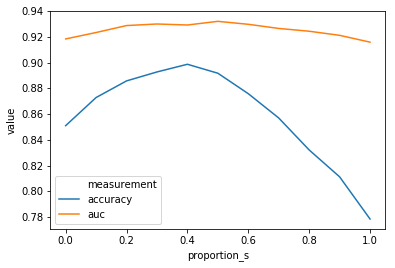

In [13]:

plot_data = (
    prop_s_data
    .set_index('proportion_s')[['accuracy', 'auc']]
    .stack()
    .rename('value')
    .reset_index()
    .rename(columns={'level_1': 'measurement'})
)

seaborn.lineplot(
    x='proportion_s',
    y='value',
    hue='measurement',
    data=plot_data,
)


In [82]:

import pickle

with open('cell_state_classifier', 'wb') as f:
    pickle.dump(model, f)
